In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/MyDrive/AN2DL/Homework2

Mounted at /gdrive
/gdrive/MyDrive/AN2DL/Homework2


In [1]:
!wget -q https://storage.googleapis.com/storage.barbiero.dev/AN2DL/Homework_2/training_data_clean.npy
!wget -q https://storage.googleapis.com/storage.barbiero.dev/AN2DL/Homework_2/categories_clean.npy
!wget -q https://storage.googleapis.com/storage.barbiero.dev/AN2DL/Homework_2/series_length_clean.npy

In [2]:
!pip install --upgrade tensorflow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.3 MB/s eta 0:00:00


In [3]:
# Fix randomness and hide warnings
seed = 42

import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np

np.random.seed(seed)

import logging

import random

random.seed(seed)

In [4]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import backend as tfkb

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [5]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

In [6]:
use_tpu = True  #@param {type:"boolean"}

if 'COLAB_TPU_ADDR' in os.environ and use_tpu:
    TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
    use_tpu = False

if use_tpu:
    tpu_address = TF_MASTER
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)

In [7]:
def print_sequence(dataset, to_plot):
    figs, axs = plt.subplots(to_plot, 1, sharex=True, figsize=(17, 17))
    n_elements = len(dataset)
    for i in range(to_plot):
        el = random.randrange(n_elements)
        axs[i].plot(dataset[el])
        axs[i].set_title(el)
    plt.show()

In [8]:
def build_sequence(data, categories, window_size=200, stride=200, telescope=18):
    actual_window = window_size + telescope

    new_categories = []
    # two dimensional array (number of series, window size)
    X = []
    # two dimensional array (number of series, telescope
    y = []

    for i, element in enumerate(data):
        length = len(element)
        new_stride = stride
        # number of windows
        n_windows = int(np.ceil((length - actual_window) / new_stride)) + 1
        if n_windows < 1:
            n_windows = 1
        # reevaluate the stride
        if n_windows > 1:
            new_stride = int((length - actual_window) / (n_windows - 1))

        # start from the end of the series
        start_idx = length - actual_window
        end_idx = length
        # for each window
        for j in range(n_windows):
            if start_idx < 0:
                start_idx = 0
                end_idx = actual_window
                if end_idx > length:
                    end_idx = length
            # append the window to X
            temp = element[start_idx:end_idx - telescope]
            X.append(temp)
            # append the telescope to y
            y.append(element[end_idx - telescope:end_idx])
            # append the category
            new_categories.append(categories[i])
            # update the start and end index
            start_idx -= new_stride
            end_idx -= new_stride

    return X, y, new_categories

In [9]:
training_data = np.load("training_data_clean.npy", allow_pickle=True)
training_data.shape

(47340, 2776)

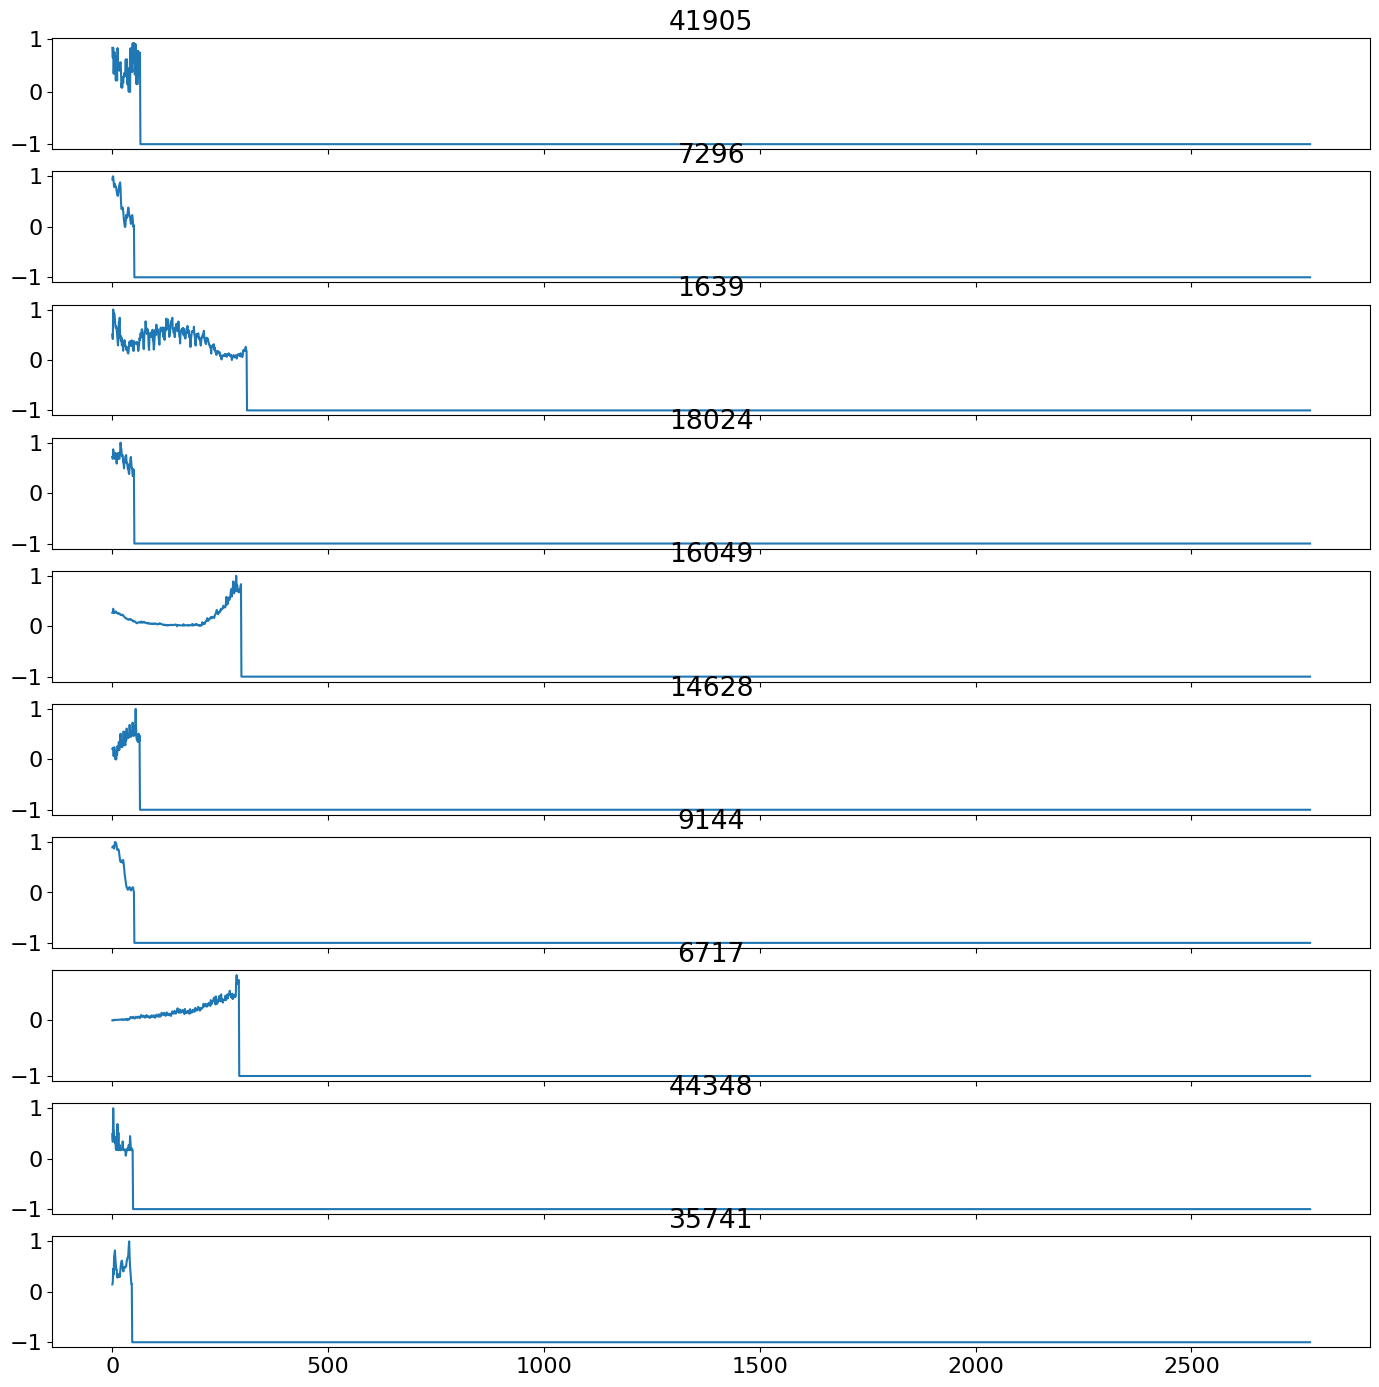

In [ ]:
print_sequence(training_data, 10)

In [10]:
categories = np.load("categories_clean.npy", allow_pickle=True)
series_lengths = np.load("series_length_clean.npy", allow_pickle=True)
categories_Set = set(categories)

#dataset = [training_data[i, :series_lengths[i]] for i in range(len(training_data))]

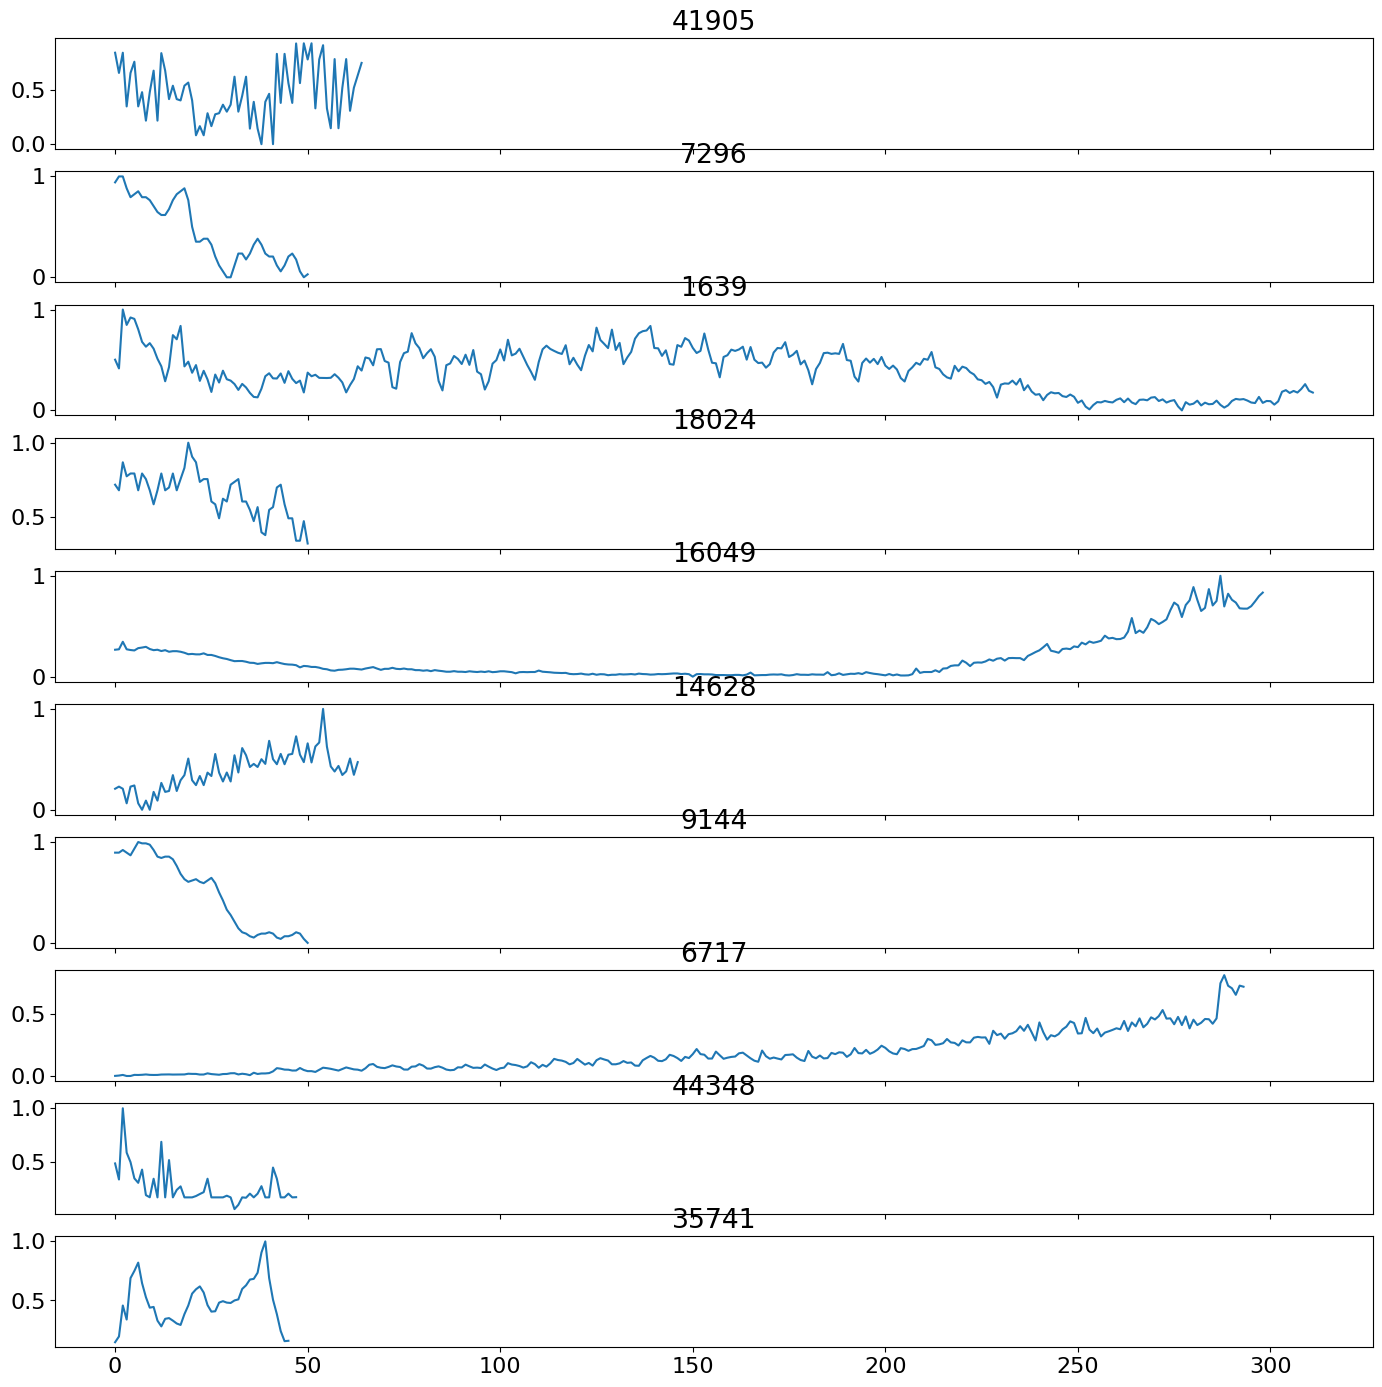

In [ ]:
print_sequence(dataset, 10)

In [11]:
from sklearn.model_selection import train_test_split

window = 150
stride = 50
telescope = 18
autoregressive_telescope = 18

# get data that has more than window + telescope elements
data_large = [training_data[i, :series_lengths[i]] for i in range(len(training_data)) if series_lengths[i] >= window + telescope]
categories_large = [categories[i] for i in range(len(training_data)) if series_lengths[i] >= window + telescope]

# split the data_large into train, validation and test
data_train, data_test, categories_train, categories_test = train_test_split(data_large, categories_large, test_size=0.1,
                                                                            stratify=categories_large)

In [12]:
X_train, y_train, categories_train = build_sequence(data_train, categories_train, window, stride, telescope)
X_test, y_test, categories_test = build_sequence(data_test, categories_test, window, stride, telescope)

In [13]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(93167, 150, 1)
(93167, 18, 1)
(10268, 150, 1)
(10268, 18, 1)


In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [16]:
# Assign the batch size
if use_tpu:
    BATCH_SIZE = 128
else:
    BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

In [17]:
def prepare_trainset(dataset):
    return (
        dataset
        .cache()
        .shuffle(1000, reshuffle_each_iteration=True)
        .repeat()
        .batch(BATCH_SIZE, drop_remainder=True)
    )


def prepare_valset(dataset):
    return (
        dataset
        .cache()
        .repeat()
        .batch(BATCH_SIZE, drop_remainder=True)
    )


train_dataset = prepare_trainset(train_dataset)
val_dataset = prepare_valset(val_dataset)

In [18]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

In [19]:
print(input_shape)
print(output_shape)

(150, 1)
(18, 1)


In [43]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')


    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(input_shape[0], return_sequences=True, name='lstm_1'), name='bidirectional_lstm_1')(input_layer)

    x = tfkl.MultiHeadAttention(num_heads=1, key_dim=input_shape[0], dropout=0.2)(x, x)

    x = tfkl.Bidirectional(tfkl.LSTM(input_shape[0], return_sequences=True, name='lstm_2'), name='bidirectional_lstm_2')(x)

    x = tfkl.Dense(units=output_shape[1], activation = 'linear')(x)

    x = tfkl.Flatten()(x)

    x = tfkl.Dense(units=output_shape[0])(x)

    output_layer = tfkl.Reshape((-1, 1))(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [20]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)
    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)
    x = tfkl.Dropout(0.3)(x)


    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(256, 3, padding='same', activation='relu')(x)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Conv1D(512, 3, padding='same', activation='relu')(x)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Conv1D(512, 3, padding='same', activation='relu')(x)
    x = tfkl.MaxPooling1D()(x)

    x = tfkl.Flatten()(x)
    x = tfkl.Dense(units = 512, activation = 'relu')(x)
    x = tfkl.Dense(units = 128, activation = 'relu')(x)
    output_layer = tfkl.Dense(units = output_shape[0])(x)

    output_layer = tfkl.Reshape((-1, 1))(output_layer)


    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [39]:
if use_tpu:
    with strategy.scope():
        model = build_CONV_LSTM_model(input_shape, output_shape)
else:
    model = build_CONV_LSTM_model(input_shape, output_shape)

Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 150, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 150, 256)             133120    ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 2a_second1_conv (Conv1D)    (None, 150, 32)              8224      ['bidirectional_lstm[0][0]']  
                                                                                                  
 2a_third1_conv (Conv1D)     (None, 150, 8)               2056      ['bidirectional_

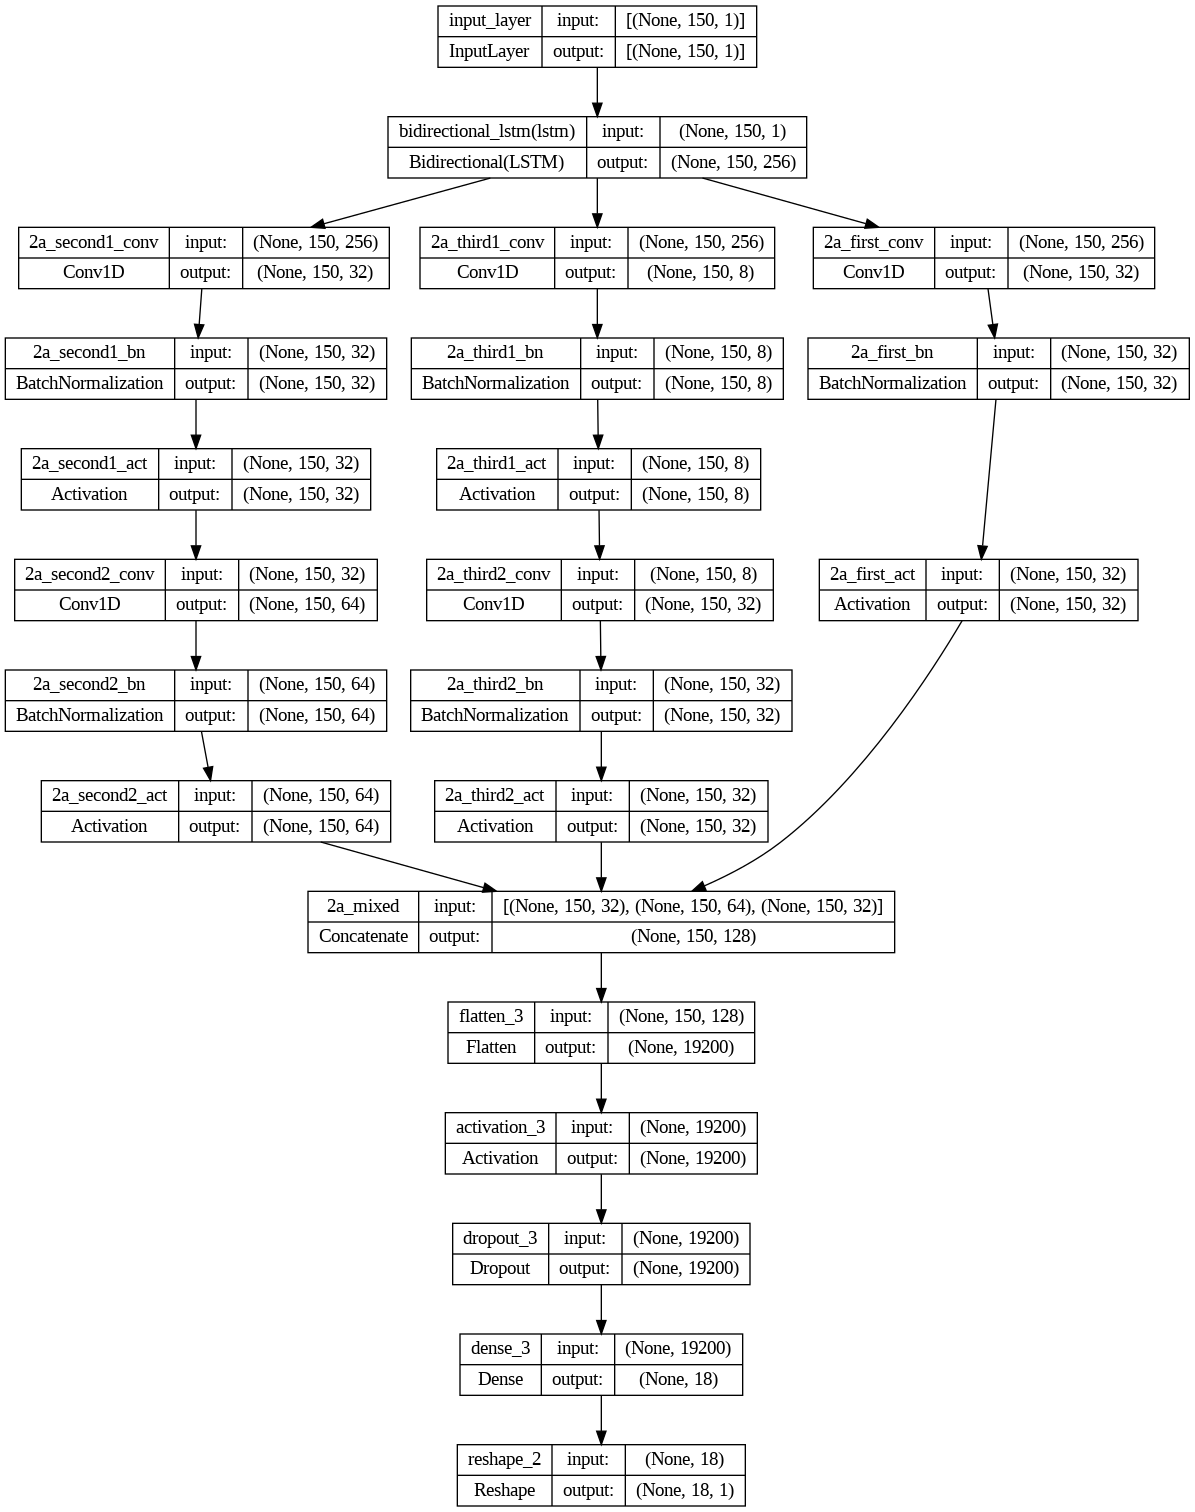

In [40]:
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [41]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=300,
    validation_data=val_dataset,
    validation_steps=len(X_test) // BATCH_SIZE,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True,
                                    min_delta=0.0005),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/300
727/727 [==============================] - 31s 29ms/step - loss: 0.0610 - val_loss: 0.0457 - lr: 0.0010
Epoch 2/300
727/727 [==============================] - 18s 25ms/step - loss: 0.0189 - val_loss: 0.0329 - lr: 0.0010
Epoch 3/300
727/727 [==============================] - 17s 23ms/step - loss: 0.0131 - val_loss: 0.0389 - lr: 0.0010
Epoch 4/300
727/727 [==============================] - 17s 23ms/step - loss: 0.0118 - val_loss: 0.0221 - lr: 0.0010
Epoch 5/300
727/727 [==============================] - 17s 23ms/step - loss: 0.0115 - val_loss: 0.0156 - lr: 0.0010
Epoch 6/300
727/727 [==============================] - 17s 23ms/step - loss: 0.0113 - val_loss: 0.0182 - lr: 0.0010
Epoch 7/300
727/727 [==============================] - 17s 23ms/step - loss: 0.0113 - val_loss: 0.0140 - lr: 0.0010
Epoch 8/300
727/727 [==============================] - 17s 23ms/step - loss: 0.0112 - val_loss: 0.0255 - lr: 0.0010
Epoch 9/300
197/727 [=======>......................] - ETA: 11s - loss: 

KeyboardInterrupt: ignored

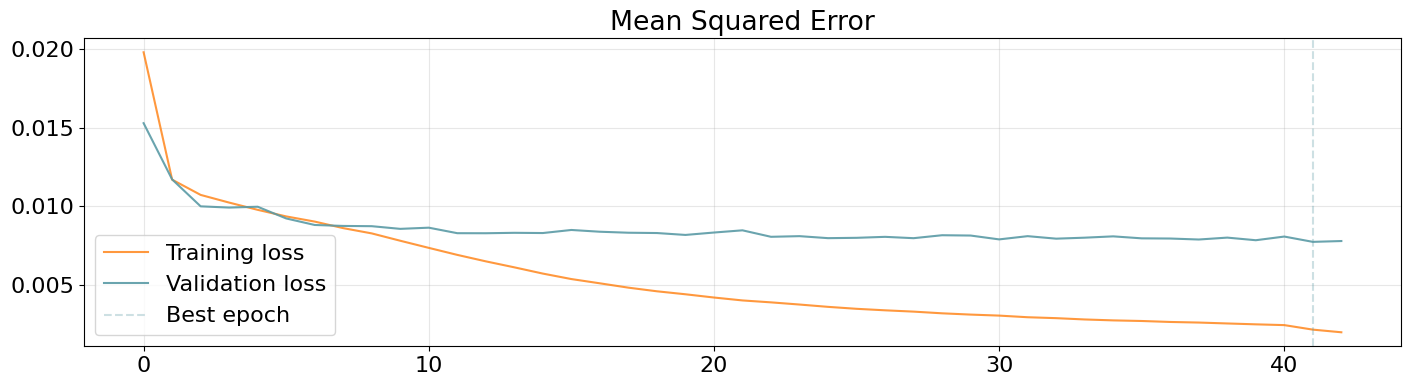

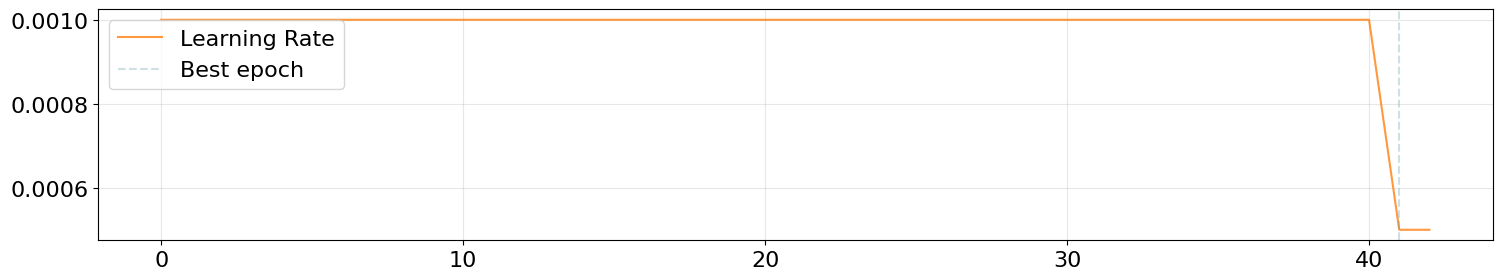

In [24]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17, 4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18, 3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [25]:
reg_predictions = np.array([])
X_temp = X_test
for reg in range(0, telescope, autoregressive_telescope):
    pred_temp = model.predict(X_temp, verbose=0)
    if (len(reg_predictions) == 0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions, pred_temp), axis=1)
    X_temp = np.concatenate((X_temp[:, autoregressive_telescope:, :], pred_temp), axis=1)

In [26]:
# Print the shape of the predictions
print(f"Predictions shape: {reg_predictions.shape}")

print("Prediction at 18:")
# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

print("Prediction at 9:")
y_test_9 = y_test[:, :9]
reg_predictions_9 = reg_predictions[:, :9]

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test_9.flatten(), reg_predictions_9.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test_9.flatten(), reg_predictions_9.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (10268, 18, 1)
Prediction at 18:
Mean Squared Error: 0.008076156489551067
Mean Absolute Error: 0.06024235114455223
Prediction at 9:
Mean Squared Error: 0.00574954180046916
Mean Absolute Error: 0.050180815160274506


In [27]:
def inspect_multivariate_prediction(X, y, pred, telescope, to_print):
    figs, axs = plt.subplots(to_print, 1, sharex=True, figsize=(17, 17))
    n_elements = X.shape[0]
    for i in range(to_print):
        el = random.randrange(n_elements)
        axs[i].plot(np.arange(len(X[el, :, 0])), X[el, :, 0])
        axs[i].plot(np.arange(len(X[el, :, 0]) - 1, len(X[el, :, 0]) + telescope - 1), y[el, :, 0], color='orange')
        axs[i].plot(np.arange(len(X[el, :, 0]) - 1, len(X[el, :, 0]) + telescope - 1), pred[el, :], color='green')
        axs[i].set_ylim(0, 1)
    plt.show()

In [54]:
def plot_window_telescope(to_print, X, y, y_pred=None):

    figs, axs = plt.subplots(to_print, 1, sharex=True, figsize=(17, 17))
    for i in range(to_print):
        # connect window and telescope
        y[i] = np.concatenate((X[i][-1:], y))
        # plot window and telescope
        axs[i].plot(np.arange(len(X[i])), X[i], label="window")
        axs[i].plot(np.arange(len(X[i]) - 1, len(X[i]) - 1 + len(y[i])), y[i], label="telescope")
        if y_pred is not None:
            y_pred[i] = np.concatenate((X[i][-1:], y_pred[i]))
            axs[i].plot(np.arange(len(X[i]) - 1, len(X[i]) - 1 + len(y_pred[i])), y_pred[i],
                    label="predicted telescope")
    plt.show()

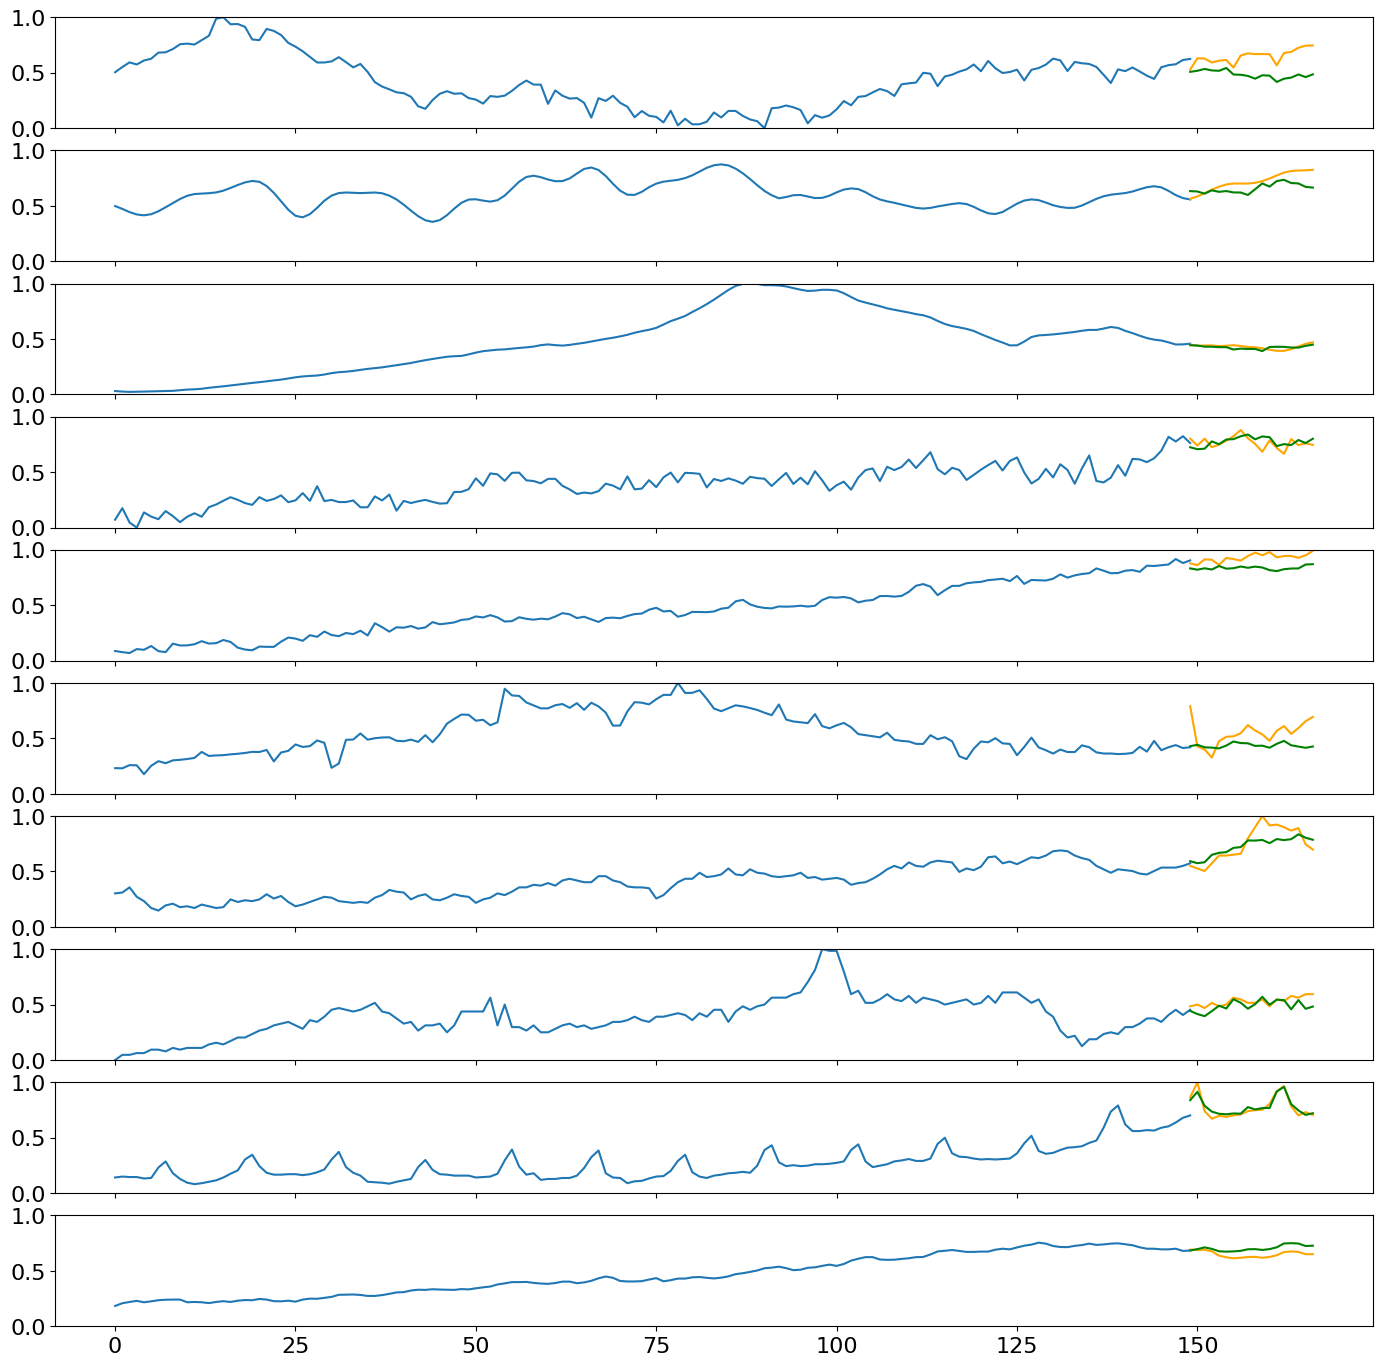

In [30]:
inspect_multivariate_prediction(X_test, y_test, reg_predictions, telescope, 10)

In [31]:
NAME_MODEL = "Bi-Bi-Conv-D"
if use_tpu:
    # save model locally from tpu using Tensorflow's "SavedModel" format
    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    model.save(NAME_MODEL, options=save_locally)
else:
    model.save(NAME_MODEL)

In [32]:
!zip -r {NAME_MODEL}.zip {NAME_MODEL}/

  adding: Bi-Bi-Conv-D/ (stored 0%)
  adding: Bi-Bi-Conv-D/fingerprint.pb (stored 0%)
  adding: Bi-Bi-Conv-D/assets/ (stored 0%)
  adding: Bi-Bi-Conv-D/saved_model.pb (deflated 90%)
  adding: Bi-Bi-Conv-D/keras_metadata.pb (deflated 93%)
  adding: Bi-Bi-Conv-D/variables/ (stored 0%)
  adding: Bi-Bi-Conv-D/variables/variables.data-00000-of-00001 (deflated 30%)
  adding: Bi-Bi-Conv-D/variables/variables.index (deflated 67%)
